In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import time

In [5]:
# initialization
# tuneable parameters
n = 10                     # the number of particle
T = 1                      # the simulation time
d = 0.00001                # the cutoff distance before annihiliation
dt_0 = 0.001               # the initial time step 
k = 0                      # first step
dummyValue = 1
#scenario = "1"

# resulting parameters
x = np.zeros((k+1,n))       # initial array for particle positions
b = np.zeros((k+1,n))       # initial array for particle charge
f = np.zeros((k+1,n))       # initial array for force term
dt = np.array([dt_0])       # initial array for variable time step
d_min = np.array([0])
d_plus = np.array([0])
tk = np.array([0])
Idn = np.eye(n)              # identity matrix
midpoint = np.array([0]) 
tkk = np.array([0]) 

# initial condition
random.seed(5)
for i in range(n):
    b[0,i] = random.uniform(-1,1)
    x[0,i] = random.uniform(0,1)
b[0] = b[0]/abs(b[0])
b[0] = b[0,np.argsort(x[0])]
x[0] = np.sort(x[0])

In [43]:
Idn

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [33]:
x[0]

array([0.11320596, 0.2167298 , 0.24657283, 0.46562265, 0.57394119,
       0.64897455, 0.74178699, 0.91634537, 0.922325  , 0.94245028])

The execution time is 0.21961259841918945 seconds


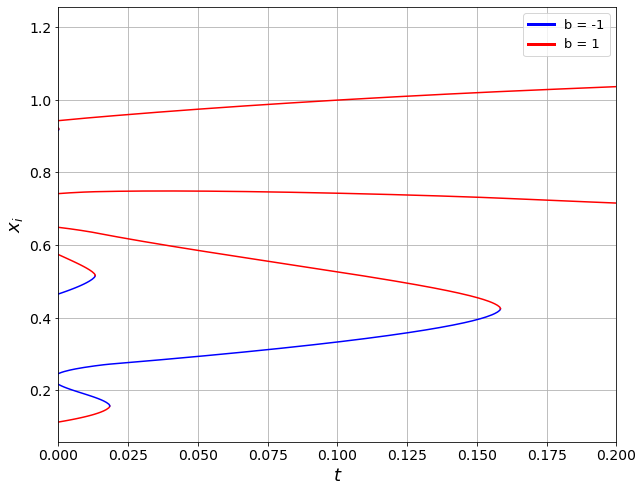

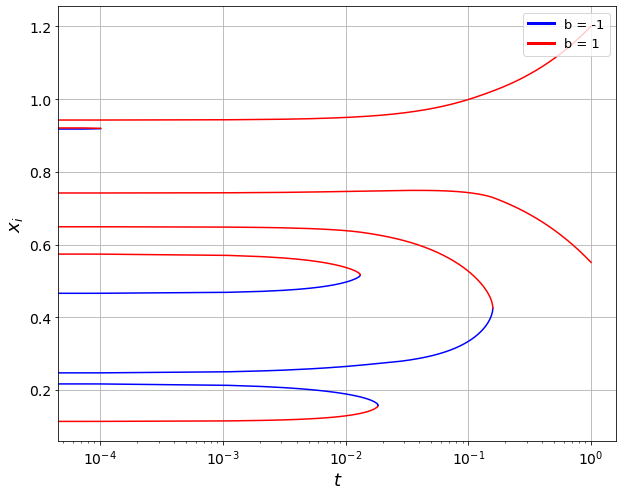

In [3]:
start_time = time.time()

# time evolution
while tk[k] < T:
    
    x_ij = np.array([x[k]]).T - x[k] 
    r = np.abs(x_ij)
    r = r + dummyValue*Idn 
    
    # new annihilation algorithm
    b_i = b[k].copy()
    #print(b_i)
    for i in range(n-1):
        if b_i[i] != 0:
            j = i+1
            while (j <= n-1) and (b_i[j] == 0):
                j += 1
        
            if j <= n-1 and (b_i[i]*b_i[j] == -1) and (np.abs(x[k,i]-x[k,j]) <= d):
                b_i[i] = 0
                b_i[j] = 0
                i = j+1
            else:
                i = j
    b = np.concatenate((b,np.array([b_i])))
    
    
    # calculating the force term
    b_ij = np.array([b[k+1]]).T * b[k+1]
    x_ij = (1/(x_ij+Idn))-Idn
    f_ij = ((x_ij*b_ij).sum(axis=1)) / n
    f = np.concatenate((f,np.array([f_ij])))
    
    
    # update to eliminate zero charge particle
    bNonZero_id = np.array(np.nonzero(b[k]))
    bUpdate = b[k,bNonZero_id]
    xUpdate = x[k,bNonZero_id]
    fUpdate = f[k+1,bNonZero_id]
    
    
    # Finding the midpoint between blue and red
    mid = np.zeros(len(bUpdate[0]))
    tkkk = np.zeros(len(bUpdate[0]))
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] + bUpdate[0,i+1]) == 0:
            md = (xUpdate[0,i] + xUpdate[0,i+1])/2
            mid[i] = md
            tkkk[i] = tk[k]
    midpoint = np.concatenate((midpoint, mid))
    tkk = np.concatenate((tkk, tkkk))
    
    # calculate d^{-}
    xdmin_minim = np.zeros(len(bUpdate[0])) + dummyValue
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] + bUpdate[0,i+1]) == -2:
            xd = np.abs(xUpdate[0,i] - xUpdate[0,i+1])
            xdmin_minim[i] = xd
    if not xdmin_minim.tolist():
        xdmin_minim = d_min
    d_min = np.concatenate((d_min,np.array([xdmin_minim.min()]))) 
    
    
    # calculate d^{+}
    xdplus_minim = np.zeros(len(bUpdate[0])) + dummyValue
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] + bUpdate[0,i+1]) == 2:
            xd = np.abs(xUpdate[0,i] - xUpdate[0,i+1])
            xdplus_minim[i] = xd
    if not xdplus_minim.tolist():
        xdplus_minim = d_plus
    d_plus = np.concatenate((d_plus,np.array([xdplus_minim.min()])))
    
    
    
    # stability condition
    fiiUpdateP = np.zeros(len(fUpdate[0]))
    xiiUpdateP = np.zeros(len(fUpdate[0]))
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] + bUpdate[0,i+1]) == 2:
            fiiUpdateP[i] = fUpdate[0,i+1] - fUpdate[0,i]
            xiiUpdateP[i] = xUpdate[0,i+1] - xUpdate[0,i] 
    h_plus = (d_plus[k+1] - xiiUpdateP[np.where(fiiUpdateP < 0)]) / fiiUpdateP[fiiUpdateP < 0]
    
    fiiUpdateM = np.zeros(len(fUpdate[0]))
    xiiUpdateM = np.zeros(len(fUpdate[0]))
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] + bUpdate[0,i+1]) == -2:
            fiiUpdateM[i] = fUpdate[0,i+1] - fUpdate[0,i]
            xiiUpdateM[i] = xUpdate[0,i+1] - xUpdate[0,i] 
    h_minus = (d_min[k+1] - xiiUpdateM[fiiUpdateM < 0]) / fiiUpdateM[fiiUpdateM < 0]
    
    
    fiiUpdateT = np.zeros(len(fUpdate[0]))
    xiiUpdateT = np.zeros(len(fUpdate[0]))
    for i in range(len(bUpdate[0]) - 1):
        if (bUpdate[0,i] * bUpdate[0,i+1]) == -1:
            fiiUpdateT[i] = fUpdate[0,i] - fUpdate[0,i+1]
            xiiUpdateT[i] = xUpdate[0,i+1] - xUpdate[0,i]
    h_T = (xiiUpdateT[fiiUpdateT > 0]) / fiiUpdateT[fiiUpdateT > 0]
    
    
    h = 0.5 * np.concatenate((h_plus, h_minus, h_T, 2*np.array([dt_0])))
    dt = np.concatenate((dt, np.array([h.min()])))
    tk = np.concatenate((tk, np.array([dt[k+1] + tk[k]])))
    
    # explicit Euler method
    x_k = x[k] + dt[k+1]*f[k+1]
    x = np.concatenate((x,np.array([x_k])))
    
    
    k += 1

    
# execution time
print("The execution time is %s seconds" % (time.time() - start_time))
    

# plotting
## position plot linear t-axis
plt.figure(1,figsize=(10,8))

for i in range(int(n)):
    #plt.plot(tk[np.where(b.T[i] == 0)[0].tolist()],x[np.where(b.T[i] == 0)[0].tolist(),i],'g')
    plt.plot(tk[np.where(b.T[i] == 1)[0].tolist()],x[np.where(b.T[i] == 1)[0].tolist(),i],'r')
    plt.plot(tk[np.where(b.T[i] == -1)[0].tolist()],x[np.where(b.T[i] == -1)[0].tolist(),i],'b')

#plt.plot(tk, np.zeros(len(tk)), 'g+')
#plt.scatter(tkk, midpoint, c='black', s=1)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x_i$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,0.2])
#plt.ylim([-0.5,1.5])
plt.grid()

custom_lines = [Line2D([0], [0], color='b', lw=3),
                Line2D([0], [0], color='r', lw=3)]

plt.legend(custom_lines, ['b = -1', 'b = 1'], loc='upper right', prop={'size': 13})

#plt.savefig("figure/EE_stable(dt-0.001,d-0.00001).pdf".format(37),bbox_inches='tight')


## position plot logarithmic t-axis
plt.figure(2,figsize=(10,8))

for i in range(int(n)):
    #plt.plot(tk[np.where(b.T[i] == 0)[0].tolist()],x[np.where(b.T[i] == 0)[0].tolist(),i],'g')
    plt.plot(tk[np.where(b.T[i] == 1)[0].tolist()],x[np.where(b.T[i] == 1)[0].tolist(),i],'r')
    plt.plot(tk[np.where(b.T[i] == -1)[0].tolist()],x[np.where(b.T[i] == -1)[0].tolist(),i],'b')

#plt.plot(tk, np.zeros(len(tk)), 'g+')
#plt.scatter(tkk, midpoint, c='black', s=1)
plt.xlabel('$t$', fontsize=18)
plt.ylabel('$x_i$', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
#plt.ylim([-0.5,1.5])
plt.grid()

custom_lines = [Line2D([0], [0], color='b', lw=3),
                Line2D([0], [0], color='r', lw=3)]

plt.legend(custom_lines, ['b = -1', 'b = 1'], loc='upper right', prop={'size': 13})

#plt.savefig("figure/EE_stable_log(dt-0.001,d-0.00001).pdf".format(37),bbox_inches='tight')

plt.show()
